In [1]:
import math
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from sklearn.cross_validation import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

D:\DevelopTools\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(1)

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
 
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
 
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


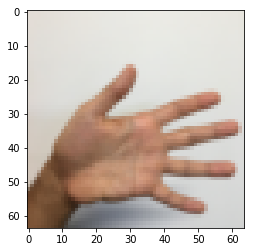

In [5]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [6]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [7]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [8]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=[n_x, None])
    Y = tf.placeholder(tf.float32, shape=[n_y, None])
    
    return X, Y

In [9]:
def initialize_parameters_deep(layer_dims):
    tf.set_random_seed(1)
    
    parameters = {}
    L = len(layer_dims)
    
    #parameters['W1'] = tf.get_variable(name='W1', [layer_dims[1], layer_dims[1-1]], initializer=tf.contrib.layers.xavier_initializer(seed=1))

    for l in range(1, L):
        parameters['W'+str(l)] = tf.get_variable('W'+str(l), [layer_dims[l], layer_dims[l-1]], initializer=tf.contrib.layers.xavier_initializer(seed=1))
        parameters['b'+str(l)] = tf.get_variable('b'+str(l), [layer_dims[l], 1], initializer=tf.zeros_initializer())
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

#test
parameters = initialize_parameters_deep((5, 4, 3))
parameters

{'W1': <tf.Variable 'W1:0' shape=(4, 5) dtype=float32_ref>,
 'W2': <tf.Variable 'W2:0' shape=(3, 4) dtype=float32_ref>,
 'b1': <tf.Variable 'b1:0' shape=(4, 1) dtype=float32_ref>,
 'b2': <tf.Variable 'b2:0' shape=(3, 1) dtype=float32_ref>}

In [10]:
def forward_propagation(X, parameters):
    L = len(parameters) // 2
    A = list(range(L+1))
    Z = list(range(L+1))
    
    A[0] = X
    for l in range(1, L):
        Z[l] = tf.add(tf.matmul(parameters['W'+str(l)], A[l-1]), parameters['b'+str(l)])
        A[l] = tf.nn.relu(Z[l])
    
    Z[L] = tf.add(tf.matmul(parameters['W'+str(L)], A[L-1]), parameters['b'+str(L)])
    
    return Z[L]

#test
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(26, 1)
    parameters = initialize_parameters_deep([26, 20, 14, 8, 2, 1])
    ZL = forward_propagation(X, parameters)
    print("ZL = " + str(ZL))

ZL = Tensor("Add_4:0", shape=(1, ?), dtype=float32)


In [11]:
def compute_cost(ZL, Y):
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

#test
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(26, 1)
    parameters = initialize_parameters_deep([26, 20, 14, 8, 2, 1])
    ZL = forward_propagation(X, parameters)
    cost = compute_cost(ZL, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
 
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def L_model(train_x, train_y, test_x, test_y, learning_rate=0.0001, epochs=1500, minibatch_size=32, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    
    n_x = train_x.shape[0]
    n_y = train_y.shape[0]
    m = train_x.shape[1]
    
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters_deep((12288, 25, 12, 6))
    
    ZL = forward_propagation(X, parameters)
    cost = compute_cost(ZL, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(train_x, train_y, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                #print(minibatch_cost)
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: train_x, Y: train_y}))
        print ("Test Accuracy:", accuracy.eval({X: test_x, Y: test_y}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572939
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381015
Cost after epoch 600: 0.313829
Cost after epoch 700: 0.254169
Cost after epoch 800: 0.203800
Cost after epoch 900: 0.166474
Cost after epoch 1000: 0.141408
Cost after epoch 1100: 0.107606
Cost after epoch 1200: 0.086730
Cost after epoch 1300: 0.061016
Cost after epoch 1400: 0.050911


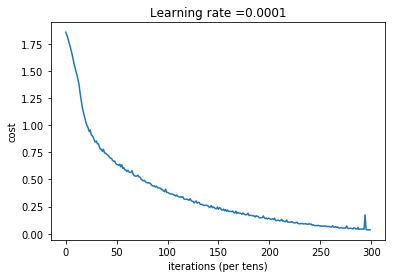

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [14]:
parameters = L_model(X_train, Y_train, X_test, Y_test)